# 2021-10-15 Some thoughts about the Bayesian behaviour observation, forgetting etc

I noted that sometimes behaviour probabilities would drop back towards 50/50 after a while in simulations with forgetting, which at first sort of seemed natural, but then when I looked closer it tended to be for example when the car braked harder than it needed to stop where the model thought it would stop - which intuitively only should make the model even more convinced that the car was stopping, rather than making it unsure. But instead it seemed that the model "slowed down" its evidence buildup for these more extreme observations, presumably related to the probability density being lower also for the more likely hypothesis at this extreme location.

So I just wanted to test this in a vanilla Bayesian observation situation, judging between two hypotheses by observing $x$, with different distributions for the two hypotheses:

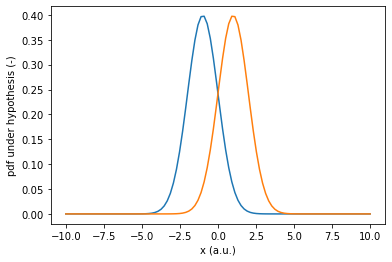

In [38]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

N_OPTS = 2
MEANS = (-1, 1)
STD_DEV = 1

xs = np.linspace(-10, 10, 100)
for i in range(N_OPTS):
    plt.plot(xs, norm.pdf(xs, MEANS[i], STD_DEV))
plt.xlabel('x (a.u.)')
plt.ylabel('pdf under hypothesis (-)')
plt.show()

Below I am confirming what I thought would be the case: In this vanilla Bayesian observation (without any forgetting), making a more extreme observation than the mode for one of the hypotheses doesn't lead to a smaller increment in belief for that most likely hypothesis, compared to making an observation at the mode of the hypothesis. And this holds true regardless of prior probabilities:

*** Updating from (0.5, 0.5)


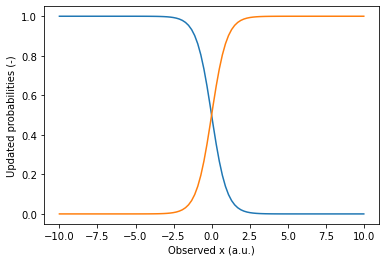

*** Updating from (0.75, 0.25)


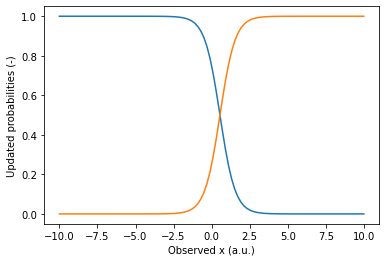

*** Updating from (0.95, 0.050000000000000044)


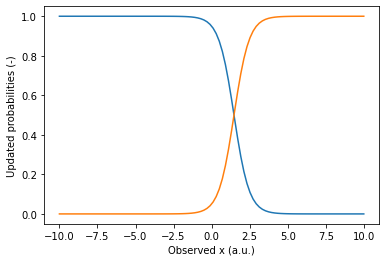

In [39]:
def one_update(curr_probs, obs_xs):
    n_obs = len(obs_xs)
    nums = np.full((N_OPTS, n_obs), math.nan)
    new_probs = np.full((N_OPTS, n_obs), math.nan)
    for i in range(N_OPTS):
        nums[i, :] = curr_probs[i] * norm.pdf(obs_xs, loc=MEANS[i], scale=STD_DEV)
    for i in range(N_OPTS):
        new_probs[i, :] = nums[i, :] / np.sum(nums, axis=0)
    return new_probs

for p1_init in (0.5, 0.75, 0.95):
    curr_probs = (p1_init, 1-p1_init)
    print(f'*** Updating from {curr_probs}')
    new_probs = one_update(curr_probs, xs)
    for i in range(N_OPTS):
        plt.plot(xs, new_probs[i, :])
    plt.xlabel('Observed x (a.u.)')
    plt.ylabel('Updated probabilities (-)')
    plt.show()

Thinking more closely about it I am realising that the mechanism for forgetting that I have built into the Bayesian observation is possibly not perfectly formulated. What happens, I believe, is that since the rate of forgetting is proportional to the accumulated evidence for the hypothesis in question (which sort of makes sense from a "neural implementation" perspective), if the evidence for one hypothesis has grown relatively strong, but then both likelihoods grow smaller (because the observations become "extreme"), the evidence buildup from those likelihoods can't match the rapid leakage from the previously high evidence. Differently put, for a given rate of forgetting, the stationary points for the evidences depend on the magnitude of the likelihoods, and based on what I showed above, over time those should converge such that "extreme" observations strongly favour the right hypothesis, but in between the evidences might have trajectories that don't do that. 

I am not a 100% sure about this however, so there's a slight lingering worry that there is something wrong about my implementation... I can't see anything obvious though.

I have been thinking a bit about potential other formulations, for example along the lines of explicitly stating that forgetting is about the possibility of the other agent changing their behaviour, such that at each time step the prior probability $P_b$ for a behaviour $b$ should be updated along the lines of:

$$
P_b' = P_b (1 - P_\Delta) + (1 - P_b) P_\Delta
$$

where $P_\Delta$ is the probability of changing behaviour from one time step to the next. In other words, the updated prior probability of behaviour $b$ is the original prior probability for that behaviour, times the probability that the behaviour hasn't changed, plus the original prior probability for "not $b$", times the probability that the behaviour has changed. If there are more than two behaviours, then one needs to consider also different transition probabilities etc, and after tinkering around with it a bit it seems to be opening a bit of a can of worms. Because there is no unique way of achieving the probability update above in terms of the evidences, so there needs to be a decision/parameter also about how one wants the sum of evidences to grow or not over time. Which doesn't make a difference in a pure `oBEo` model, but does in combination with `oBEv`. 

So my overall takeaway at the moment is sort of: For long forgetting time constants $T_{Of}$ things seem sort of well behaved, so let's maybe leave it at that for now, but keep an eye out in case there is actually some deeper mathematical or implementation problem with how I have done the forgetting.